In [1]:
from IPython.display import HTML
HTML('''<h2>IMT 575: Sagemaker trial model</h2>
<b><pre>
    Authors: 
    Aftab Alam
    </pre>
</b> 
<p>Date/Time: <span id="datetime"></span></p><script>var dt = new Date();
document.getElementById("datetime").innerHTML=dt.toLocaleString();</script> </p>''')

In [2]:
# enable flag to how all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sys
! conda install -y -c conda-forge ipywidgets
! pip install tldextract


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - ipywidgets


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-3.6.7               |    h381d211_1004        34.5 MB  conda-forge
    pykerberos-1.2.1           |   py36h2afdebe_2          27 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    matplotlib-base-3.1.0      |   py36h5f35d83_0         6.7 MB  conda-forge
    freetype-2.10.1            |       he06d7ca_0         877 KB  conda-forge
    libiconv-1.15              |    h516909a_1006         2.0 MB  conda-forge
    libcurl-7.69.1             |       hf7181ac_0  

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import time
import sys
import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.predictor import csv_serializer

In [3]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket and prefix
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/xgboost'
# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

In [4]:
%%time
# split data and save in s3

import io
import boto3
import random
from sklearn.model_selection import train_test_split

def appendXY(X,Y):
    df = pd.DataFrame(Y)
    df.columns = ['Y']
    dfx = pd.DataFrame(X)
    return pd.concat([df,dfx],axis=1)
   

def data_split(features,output_label,train_file, validation_file, test_file,test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split( features, output_label, test_size=test_size, random_state=random_state)
    #print(y_test)
    test_df = appendXY(X_test,y_test)
    test_df.to_csv(test_file,header=False,index=False)
    
    X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=test_size, random_state=random_state)
    train_df = appendXY(X_train,y_train)
    train_df.to_csv(train_file,header=False,index=False)
    
    valid_df = appendXY(X_test,y_test)
    valid_df.to_csv(validation_file,header=False,index=False)


def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 313 ms, sys: 68 ms, total: 381 ms
Wall time: 923 ms


In [5]:
# download file from S3
FILE_DATA = 'domainsDataSet'
s3 = boto3.client('s3')
s3.download_file(bucket, 'newDataSample.csv', FILE_DATA)

In [6]:
# Load the dataset
df_domains = pd.read_csv(FILE_DATA)

df_domains.tail()
df_domains.head()
df_domains.groupby('domain_type').agg('count')

,domain
domain_type,
benign,499999
dga,500000


In [14]:
df_domains.columns

Index(['domain', 'domain_type'], dtype='object')

In [7]:
import tldextract

def extract_domain_subdomain(record):
    domain = record.domain
    ret=''
    try:
        ext = tldextract.extract(domain)
        ret = ext.domain
    except :
        print(record)
    return ret
def get_y(row):
    if row.domain_type.lower()=='dga':
        return 1
    elif row.domain_type.lower()=='benign':
        return 0
    else :
        return 1
    
df_domains.loc[:,'domain_subdomain'] = df_domains.apply(lambda row : extract_domain_subdomain(row), axis=1 )
## 1 for dga and 0 for benign
df_domains.loc[:,'Y'] = df_domains.apply(lambda row : get_y(row), axis=1 )

domain            NaN
domain_type    benign
Name: 765103, dtype: object


In [8]:
def pad(l, content, width):
        l.extend([content] * (width - len(l)))
        return l
def features_extract(domain):
    ch_list = []
    for ch in domain :
        ch_int = ord(ch)
        ch_list = [*ch_list,ch_int]
    # pad zeros up to 63 length
    return pad(ch_list,0,63)

In [17]:
## tldextract example
url = 'https://www.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcde.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk.com'
ext=tldextract.extract(url)
len(features_extract(ext.domain))
ext.domain

63

'abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzabcdefghijk'

In [9]:
# features X
X = [features_extract(D) for D in df_domains.domain_subdomain]
#df = pd.DataFrame(X)
#df.insert(loc=0,column='Y',value=df_domains['Y'])
#df.to_csv('dataset.csv',header=False,index=False)


In [64]:
X.index

<function list.index>

In [ ]:
%%time
# split df in training , validation and test and save as file
FILE_TRAIN = 'domainsDataSet.train'
FILE_VALIDATION = 'domainsDataSet.validation'
FILE_TEST = 'domainsDataSet.test'

data_split(features=X,output_label=df_domains['Y'].values,train_file=FILE_TRAIN
           ,validation_file=FILE_VALIDATION, test_file=FILE_TEST,test_size=0.2, random_state=42)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)


In [132]:
# create input
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

ValueError: Algorithm class:deep-arr does not have mapping to account_id with images

In [125]:
# train model
from sagemaker.amazon.amazon_estimator import get_image_uri
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name


container = get_image_uri(region, 'xgboost','0.90-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

# fitting model with default parameters
xgb.set_hyperparameters(base_score=0.5, 
                        booster=None, 
                        colsample_bylevel=1,
                        colsample_bynode=1, 
                        colsample_bytree=1, 
                        gamma=0, 
                        gpu_id=-1, 
                        max_delta_step=0, max_depth=6,
                        min_child_weight=1,
                         random_state=0, alpha=0,
                         scale_pos_weight=1, subsample=1, tree_method=None,
                         verbosity=None,
                        eta=0.3,
                        silent=1,
                        objective='binary:logistic',
                        num_round=400,
                        eval_metric='error')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-05-07 19:45:01 Starting - Starting the training job...
2020-05-07 19:45:03 Starting - Launching requested ML instances..

KeyboardInterrupt: 

In [71]:
!pip install pickle-mixin
!pip install xgboost==0.90

You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [97]:
import tarfile
import pickle as pkl

path_key = f'{prefix}/output/sagemaker-xgboost-2020-05-07-12-31-15-641/output'
# download the model artifact from AWS S3
s3 = boto3.client('s3')
s3.download_file(bucket, f'{path_key}/model.tar.gz', 'model.tar.gz')

! ls -lrt


#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
file = open('xgboost-model', 'rb')
model = pkl.loads(file.read())

total 392184
-rw-r--r-- 1 ec2-user ec2-user     41578 May  7 12:35 xgboost-model
-rw-rw-r-- 1 ec2-user ec2-user     38471 May  7 15:34 Build-and-Deploy-DGA.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 185679638 May  7 15:51 dataset.csv
-rw-rw-r-- 1 ec2-user ec2-user  30034250 May  7 16:00 domainsDataSet
-rw-rw-r-- 1 ec2-user ec2-user  37131903 May  7 17:04 domainsDataSet.test
-rw-rw-r-- 1 ec2-user ec2-user 118841199 May  7 17:05 domainsDataSet.train
-rw-rw-r-- 1 ec2-user ec2-user  29706536 May  7 17:06 domainsDataSet.validation
-rw-rw-r-- 1 ec2-user ec2-user     91527 May  7 17:57 Build-deploy-dga.ipynb
-rw-rw-r-- 1 ec2-user ec2-user       146 May  7 17:58 single.test
-rw-rw-r-- 1 ec2-user ec2-user     11553 May  7 17:58 model.tar.gz


In [96]:
!head -1 domainsDataSet.test > single.test

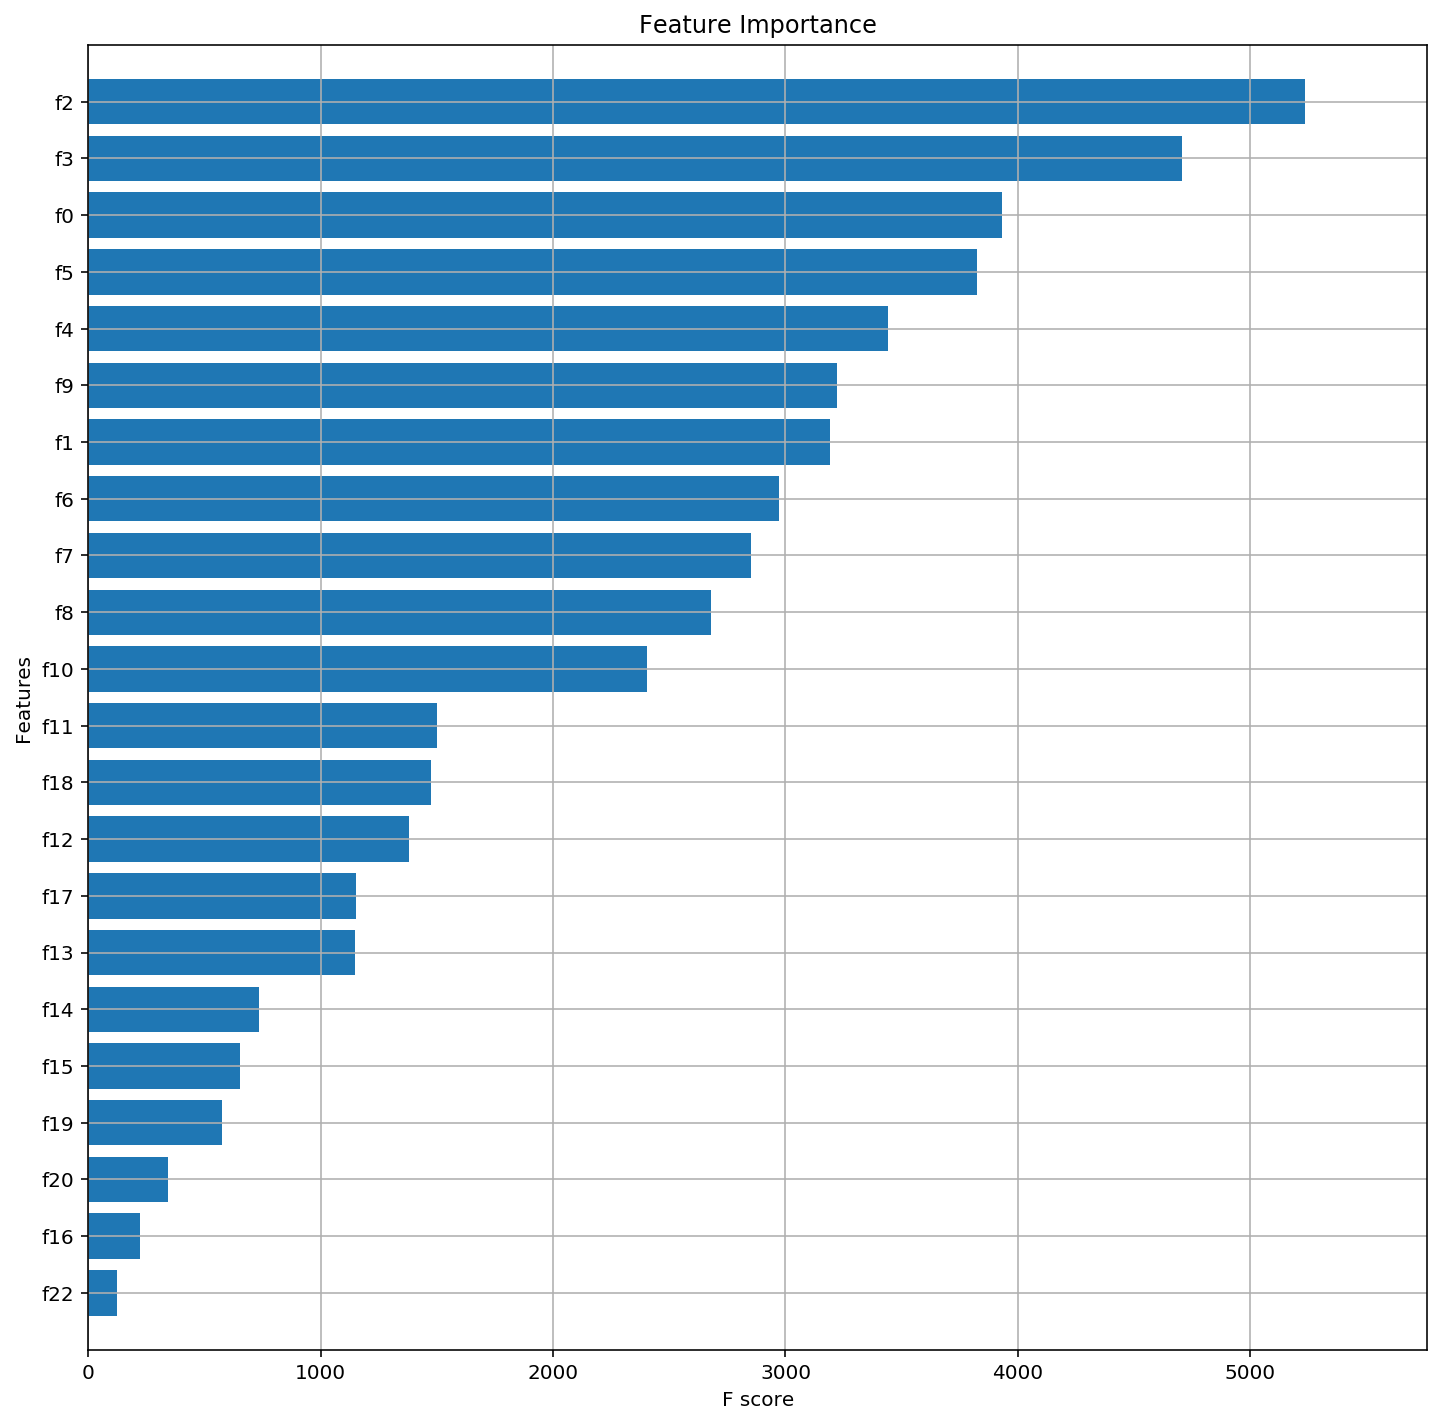

In [73]:
import xgboost
#map_names = dict(zip(model.feature_names, df_domains.columns))
#model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

In [29]:
## Deploy trained XGBoost model endpoint to perform predictions
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')





Using already existing model: sagemaker-xgboost-2020-05-07-16-07-44-923


---------------!

NameError: name 'csv_serializer' is not defined

In [74]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None


In [81]:
!head -10 domainsDataSet.test > single.test

In [88]:
## Function to chunk down test set into smaller increments

def predict(data, model, rows=500):
    split_array = np.array_split(data, int(len(data) / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, model.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

## Generate predictions on the test set for the difference models
with open('single.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line.split(',')[0]) for line in payload.split('\n')]
test_data = [line.split(',')[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
predictions

array([0.32016069, 0.32141834, 0.32474303, 0.31485152, 0.31776819,
       0.30617973, 0.32085258, 0.32062224, 0.31752226, 0.32174331])

In [90]:
## Generate predictions on the test set for the difference models
with open('domainsDataSet.test', 'r') as f:
    payload = f.read().strip()
labels = [int(line.split(',')[0]) for line in payload.split('\n')]
test_data = [line.split(',')[2:] for line in payload.split('\n')]
predictions = predict(test_data, xgb_predictor)
#xgb_predictor.predict(payload[2:]).decode('utf-8')
from sklearn.metrics import accuracy_score ,confusion_matrix
thresh = 0.5
y_pred = predictions
y_pred_binary = np.where(predictions > thresh, 1, 0)
accuracy_score(labels,y_pred_binary)
confusion_matrix(labels,y_pred_binary)

array([[127773,      4],
       [127234,      0]])

In [92]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'colsample_bylevel': ContinuousParameter(0.1, 1,scaling_type="Logarithmic"),
    'colsample_bytree': ContinuousParameter(0.5, 1, scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'gamma':ContinuousParameter(0, 5, scaling_type='Auto'),
    'lambda': ContinuousParameter(0,100,scaling_type='Auto'),
    'max_delta_step': IntegerParameter(0,10,scaling_type='Auto'),
    'max_depth': IntegerParameter(0,10,scaling_type='Auto'),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic')}

objective_metric_name = 'validation:auc'

tuner_log = HyperparameterTuner(
    xgb,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=60,
    max_parallel_jobs=2,
    strategy='Bayesian'
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'InProgress'

In [95]:
client_sag= boto3.client('sagemaker')
status = client_sag.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status =  client_sag.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
    print(status)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress


KeyboardInterrupt: 